In [1]:
#Import necessary libraries
import numpy as np
import pandas as pd
import scipy.sparse as sp
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [53]:
#Load and explore pre-processed text
df = pd.read_csv('processced text.csv')
#df

In [3]:
#Load TF-IDF Matrix
tfidf = sp.load_npz('tfidf_matrix.npz')
tfidf

<7064x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 159313 stored elements in Compressed Sparse Row format>

In [4]:
#Get previously fit vectorizer
with open('out/count_vectorizer.pkl', 'rb') as f:
    tfidf_vect = pickle.load(f)
feature_names = tfidf_vect.get_feature_names_out()

/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/base.py:347: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.4.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [5]:
#Set random state
random_state = 696

**Initially Test and Explore NMF with 2 Topics**

In [40]:
nmf = NMF(n_components = 2, random_state = random_state, max_iter = 200, init = 'nndsvd')
W = nmf.fit_transform(tfidf)
H = nmf.components_

In [41]:
#Print W Matrix --> Steps from SIADS 543 NMF Lecture
def print_W_matrix(W, num_topics):
    for idx in range(0,num_topics):
        top_indices = np.argsort(W[:, idx])[::-1]
        #See top 3 documents for each topic
        for doc_idx in top_indices[0:3]:
            doc = df['preprocessed_text'][doc_idx]
            print("Topic", idx+1,':', "Doc Idx",':', doc_idx, "Document Snippet:",doc[:100])

In [48]:
#Print H Matrix --> Steps from SIADS 543 NMF Lecture
def print_H_matrix(H, num_topics):
    for idx in range(0,num_topics):
            top_indices = np.argsort(H[idx, :])[::-1]
            top_indices = H[idx].argsort()[:-50:-1]
            top_terms = []
            #Initially see top 50 Terms for a topic
            for term_idx in top_indices[:50]:  
                top_terms.append(feature_names[term_idx])
            print('Topic', idx+1, top_terms) 
            #for i in top_indices[:5]:
            #print(feature_names[i])

In [43]:
def get_topic_words(H,num_topics):
    term_lists = []
    for idx in range(0,num_topics):
        top_indices = np.argsort(H[idx, :])[::-1]
        #top_terms = []
        #Initially see top 50 Terms for a topic
        #for term_idx in top_indices:  
        term_lists.append([feature_names[term_idx] for term_idx in top_indices[:50]])
        #print("topic ", idx, top_terms)  
    return term_lists

In [46]:
print_W_matrix(W,2)

Topic 1 : Doc Idx : 4891 Document Snippet: warmonger late lose dignity donald trump say donald trump may transform american politic kleptocrati
Topic 1 : Doc Idx : 5818 Document Snippet: white house invitation rodrigo duterte philippine erodes americas reputation united states long see 
Topic 1 : Doc Idx : 4211 Document Snippet: vision islam inherently hostile long flourish far right president trump bring view white house washi
Topic 2 : Doc Idx : 1053 Document Snippet: new york new york new year day
Topic 2 : Doc Idx : 1138 Document Snippet: public service affect new york new year day schedule new york region new york city new jersey connec
Topic 2 : Doc Idx : 2362 Document Snippet: new york new york information voter new jersey elections new york city


In [50]:
print_H_matrix(H,2)

Topic 1 ['ayanna', 'audition', 'awe', 'alshariah', 'armenia', 'arkansas', 'aka', 'arctic', 'airborne', 'aspen', 'amc', 'bacteria', 'apron', 'aston', 'achille', 'amtrak', 'azerbaijan', 'armenian', 'alexandria', 'anymore', 'agree', 'absolute', 'allege', 'atheism', 'audioneutralinformative', 'agricultural', 'backward', 'ahead', 'afford', 'axelrod', 'adolescent', 'badly', 'asianamericans', 'baldwin', 'arabia', 'balcony', 'affairs', 'angst', 'bahama', 'appoint', 'associated', 'assert', 'airwave', 'anthology', 'airtime', 'ballet', 'americans', 'affix', 'andr']
Topic 2 ['apply', 'ballot', 'adorn', 'ballet', 'acrobatic', 'anticipation', 'baffert', 'alabamas', 'agency', 'approve', 'audioneutralinformative', 'ancestry', 'arbor', 'ann', 'affluence', 'astonishing', 'average', 'ayn', 'assure', 'alienation', 'arabian', 'ark', 'anthology', 'aston', 'antisemitic', 'adventure', 'balance', 'amazoncom', 'anthropologist', 'advocate', 'awry', 'almeida', 'april', 'antony', 'approval', 'actually', 'arenas', 

**Looks like with just two topics the topics are split into a category with terms referring more to leisure and another category with terms referring to politics and world news according to the H matrix. The W matrix confirms this by seeming to match world news/politics articles to topic 1 and others to topic 0**

**Now do some hyperparamter tuning to find the best mix of hyperparamters (n_components, etc.) to get the number of topics that will have the least average cosine similarity. This will indicate that the topics are distinct from one another.**

In [72]:
best_avg_sim = float('inf')
best_model = None
best_W = None
best_H = None
for num_topics in range(3,20):
    for num_iter in range(200,2000,100):
        running_sim_total = []

        nmf = NMF(n_components = num_topics, max_iter = num_iter, init = 'nndsvd', random_state = random_state)
        W = nmf.fit_transform(tfidf)
        H = nmf.components_


        topic_terms = [' '.join(topic_words) for topic_words in get_topic_words(H, num_topics)]

        for t1 in topic_terms:
            for t2 in topic_terms:
                if t1 != t2:
                    running_sim_total.append(cosine_similarity(tfidf_vect.transform([t1]), 
                                                                   tfidf_vect.transform([t2]))[0][0])

        avg_sim = np.mean(running_sim_total)

        if avg_sim < best_avg_sim:
            best_avg_sim = avg_sim
            best_model = nmf
            best_W = W
            best_H = H
            
                    

/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 300 reached. Increase it to improve convergence.
  warnings.warn(
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/yashdave/anaconda3/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve 

In [73]:
best_model

NMF(init='nndsvd', n_components=3, random_state=696)

In [74]:
best_avg_sim

0.04666666666666667

**The best model parameters is with init = nndsvd, n_components = 3, and max_iter = 200. Now let's look at the best model more closely.**

<Axes: >

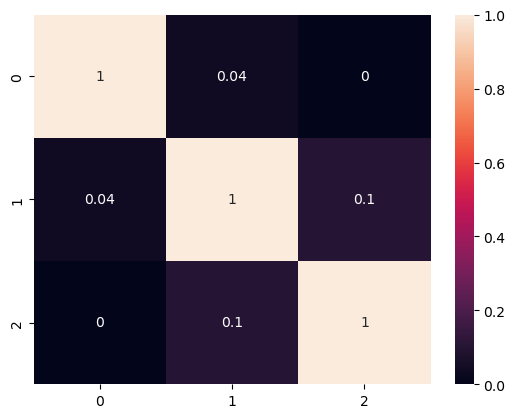

In [68]:
#Heatmap to show cosine similarities between each topic in best NMF model
c_mat = []
topic_terms = [' '.join(topic_words) for topic_words in get_topic_words(best_H, 3)]
for t1 in topic_terms:
    for t2 in topic_terms:
        c_mat.append(cosine_similarity(tfidf_vect.transform([t1]),tfidf_vect.transform([t2]))[0][0])
c_mat = np.array(c_mat).reshape(3,3)
sns.heatmap(c_mat, annot = True)

**Lets look at what each topic looks like for the best model**

In [69]:
print_H_matrix(best_H, 3)

Topic 1 ['ayanna', 'awe', 'audition', 'alshariah', 'armenia', 'arkansas', 'aka', 'airborne', 'arctic', 'aspen', 'amc', 'bacteria', 'apron', 'achille', 'aston', 'armenian', 'amtrak', 'azerbaijan', 'anymore', 'agree', 'alexandria', 'atheism', 'absolute', 'allege', 'agricultural', 'audioneutralinformative', 'backward', 'axelrod', 'ahead', 'afford', 'asianamericans', 'adolescent', 'bahama', 'arabia', 'badly', 'angst', 'associated', 'baldwin', 'andr', 'airwave', 'affairs', 'americans', 'airtime', 'appoint', 'balcony', 'assert', 'affix', 'angola', 'abduction']
Topic 2 ['apply', 'ballot', 'adorn', 'ballet', 'acrobatic', 'agency', 'audioneutralinformative', 'arbor', 'ancestry', 'average', 'aston', 'ark', 'anthology', 'astonishing', 'approve', 'alienation', 'almeida', 'amazoncom', 'arenas', 'awry', 'ann', 'apprentice', 'april', 'advocate', 'adventure', 'anthony', 'allow', 'annal', 'approval', 'bag', 'baker', 'apostle', 'astro', 'ai', 'balance', 'angelique', 'ansar', 'ayn', 'atrocity', 'arise', 

In [70]:
print_W_matrix(best_W, 3)

Topic 1 : Doc Idx : 4891 Document Snippet: warmonger late lose dignity donald trump say donald trump may transform american politic kleptocrati
Topic 1 : Doc Idx : 5818 Document Snippet: white house invitation rodrigo duterte philippine erodes americas reputation united states long see 
Topic 1 : Doc Idx : 4211 Document Snippet: vision islam inherently hostile long flourish far right president trump bring view white house washi
Topic 2 : Doc Idx : 1053 Document Snippet: new york new york new year day
Topic 2 : Doc Idx : 1138 Document Snippet: public service affect new york new year day schedule new york region new york city new jersey connec
Topic 2 : Doc Idx : 2362 Document Snippet: new york new york information voter new jersey elections new york city
Topic 3 : Doc Idx : 1716 Document Snippet: couple meet stanford graduate distinction mary catherine jones alexander mitchell fenner marry satur
Topic 3 : Doc Idx : 4524 Document Snippet: couple marry scarsdale congregational church scar